Updating data.......................................................

...

               '1984-11-15 14:30:00+00:00', '1984-11-19 14:30:00+00:00',
               '1984-12-28 14:30:00+00:00', '1985-01-02 14:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


...

...................................................................

....................................................................

               '1974-06-04 13:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


..........

...............

.........................................

.............

............

............

.............

.........................................................................

.............................................

               '1977-05-11 13:30:00+00:00', '1977-05-12 13:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


..................

...

.........

.....

............

..........................
## RESULT

#################################################################
Universe size                                                 502
Initial timestamp                       2019-03-25 13:30:00+00:00
Final timestamp                         2024-03-22 13:30:00+00:00
Number of periods                                            1259
Initial value (USDOLLAR)                                1.000e+06
Final value (USDOLLAR)                                  3.113e+06
Profit (USDOLLAR)                                       2.113e+06
                                                                 
Avg. return (annualized)                                    53.4%
Volatility (annualized)                                     77.3%
Avg. excess return (annualized)                             51.4%
Avg. active return (annualized)                             51.4%
Excess volatility (annualized)                              77.3%
Active volatility (annualized)        

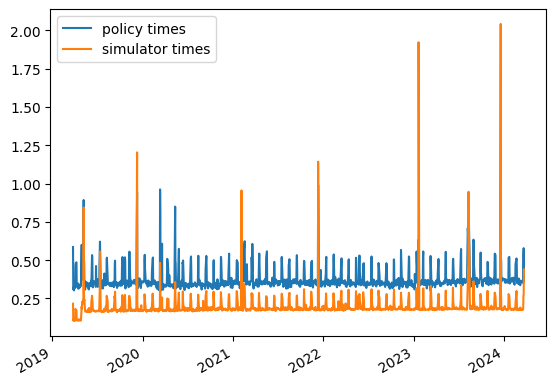

In [ ]:
### CPU

import time

import matplotlib.pyplot as plt
import pandas as pd

import cvxportfolio as cvx

from universes import SP500

# we test the typical time it takes
# to solve and simulate an SPO policy,
# in the same way as we did in Figure
# 7.8 of the book

# NOTE: the first time you run this, it will
# compute and cache the risk model terms (for
# each day). The second time you run you should
# see faster runtime.

# changing these may have some effect
# on the solver time, but small
GAMMA_RISK = 1.
GAMMA_TRADE = 1.
GAMMA_HOLD = 1.

# the solve time grows linearly
# with this. 15 is the same number
# we had in the book examples
NUM_RISK_FACTORS = 15

# if you change this to 2 (quadratic model)
# the resulting problem is a QP and can be
# solved faster
TCOST_EXPONENT = 1.5

# you can add any constraint or objective
# term to see how it affects execution time
policy = cvx.SinglePeriodOptimization(
    objective = cvx.ReturnsForecast()
        - GAMMA_RISK * cvx.FactorModelCovariance(num_factors=NUM_RISK_FACTORS)
        - GAMMA_TRADE * cvx.StocksTransactionCost(exponent=TCOST_EXPONENT)
        - GAMMA_HOLD * cvx.StocksHoldingCost(),
    constraints = [
        cvx.LeverageLimit(3),
    ],

    # You can select any CVXPY
    # solver here to see how it
    # affects performance of your
    # particular problem. This one
    # is the default for this type
    # of problems.
    solver='ECOS',

    # this is a CVXPY compilation flag, it is
    # recommended for large optimization problems
    # (like this one) but not for small ones
    ignore_dpp=True,

    # you can add any other cvxpy.Problem.solve option
    # here, see https://www.cvxpy.org/tutorial/advanced/index.html
)

# this downloads data for all the sp500
simulator = cvx.StockMarketSimulator(SP500)

# execution and timing, 5 years backtest
s = time.time()
result = simulator.backtest(
    policy, start_time=pd.Timestamp.today() - pd.Timedelta(f'{365.24*5}d'))

print('## RESULT')
print(result)

print('BACKTEST TOOK:', time.time() - s)
print(
    'SIMULATOR + POLICY TIMES:',
    result.simulator_times.sum() + result.policy_times.sum())
print(
    'AVERAGE TIME PER ITERATION:',
    result.simulator_times.mean() + result.policy_times.mean())

# plot
result.policy_times.plot(label='policy times')
result.simulator_times.plot(label='simulator times')
plt.legend()
plt.show()

Updating data.......................................................

...

               '1984-11-15 14:30:00+00:00', '1984-11-19 14:30:00+00:00',
               '1984-12-28 14:30:00+00:00', '1985-01-02 14:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


...

...................................................................

....................................................................

               '1974-06-04 13:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


..........

...............

.........................................

.............

............

............

.............

.........................................................................

.............................................

               '1977-05-11 13:30:00+00:00', '1977-05-12 13:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


..................

...

.........

.....

............

..........................
## RESULT

#################################################################
Universe size                                                 502
Initial timestamp                       2019-03-25 13:30:00+00:00
Final timestamp                         2024-03-22 13:30:00+00:00
Number of periods                                            1259
Initial value (USDOLLAR)                                1.000e+06
Final value (USDOLLAR)                                  3.113e+06
Profit (USDOLLAR)                                       2.113e+06
                                                                 
Avg. return (annualized)                                    53.4%
Volatility (annualized)                                     77.3%
Avg. excess return (annualized)                             51.4%
Avg. active return (annualized)                             51.4%
Excess volatility (annualized)                              77.3%
Active volatility (annualized)        

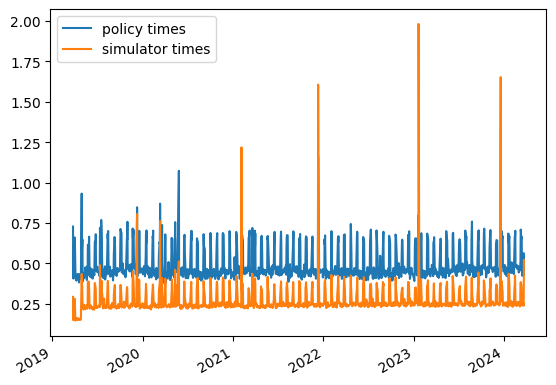

In [ ]:
### GPU

import time

import matplotlib.pyplot as plt
import pandas as pd

import cvxportfolio as cvx

from universes import SP500

# we test the typical time it takes
# to solve and simulate an SPO policy,
# in the same way as we did in Figure
# 7.8 of the book

# NOTE: the first time you run this, it will
# compute and cache the risk model terms (for
# each day). The second time you run you should
# see faster runtime.

# changing these may have some effect
# on the solver time, but small
GAMMA_RISK = 1.
GAMMA_TRADE = 1.
GAMMA_HOLD = 1.

# the solve time grows linearly
# with this. 15 is the same number
# we had in the book examples
NUM_RISK_FACTORS = 15

# if you change this to 2 (quadratic model)
# the resulting problem is a QP and can be
# solved faster
TCOST_EXPONENT = 1.5

# you can add any constraint or objective
# term to see how it affects execution time
policy = cvx.SinglePeriodOptimization(
    objective = cvx.ReturnsForecast()
        - GAMMA_RISK * cvx.FactorModelCovariance(num_factors=NUM_RISK_FACTORS)
        - GAMMA_TRADE * cvx.StocksTransactionCost(exponent=TCOST_EXPONENT)
        - GAMMA_HOLD * cvx.StocksHoldingCost(),
    constraints = [
        cvx.LeverageLimit(3),
    ],

    # You can select any CVXPY
    # solver here to see how it
    # affects performance of your
    # particular problem. This one
    # is the default for this type
    # of problems.
    solver='ECOS',

    # this is a CVXPY compilation flag, it is
    # recommended for large optimization problems
    # (like this one) but not for small ones
    ignore_dpp=True,

    # you can add any other cvxpy.Problem.solve option
    # here, see https://www.cvxpy.org/tutorial/advanced/index.html
)

# this downloads data for all the sp500
simulator = cvx.StockMarketSimulator(SP500)

# execution and timing, 5 years backtest
s = time.time()
result = simulator.backtest(
    policy, start_time=pd.Timestamp.today() - pd.Timedelta(f'{365.24*5}d'))

print('## RESULT')
print(result)

print('BACKTEST TOOK:', time.time() - s)
print(
    'SIMULATOR + POLICY TIMES:',
    result.simulator_times.sum() + result.policy_times.sum())
print(
    'AVERAGE TIME PER ITERATION:',
    result.simulator_times.mean() + result.policy_times.mean())

# plot
result.policy_times.plot(label='policy times')
result.simulator_times.plot(label='simulator times')
plt.legend()
plt.show()

In [ ]:
### TPU

import time

import matplotlib.pyplot as plt
import pandas as pd

import cvxportfolio as cvx

from universes import SP500

# we test the typical time it takes
# to solve and simulate an SPO policy,
# in the same way as we did in Figure
# 7.8 of the book

# NOTE: the first time you run this, it will
# compute and cache the risk model terms (for
# each day). The second time you run you should
# see faster runtime.

# changing these may have some effect
# on the solver time, but small
GAMMA_RISK = 1.
GAMMA_TRADE = 1.
GAMMA_HOLD = 1.

# the solve time grows linearly
# with this. 15 is the same number
# we had in the book examples
NUM_RISK_FACTORS = 15

# if you change this to 2 (quadratic model)
# the resulting problem is a QP and can be
# solved faster
TCOST_EXPONENT = 1.5

# you can add any constraint or objective
# term to see how it affects execution time
policy = cvx.SinglePeriodOptimization(
    objective = cvx.ReturnsForecast()
        - GAMMA_RISK * cvx.FactorModelCovariance(num_factors=NUM_RISK_FACTORS)
        - GAMMA_TRADE * cvx.StocksTransactionCost(exponent=TCOST_EXPONENT)
        - GAMMA_HOLD * cvx.StocksHoldingCost(),
    constraints = [
        cvx.LeverageLimit(3),
    ],

    # You can select any CVXPY
    # solver here to see how it
    # affects performance of your
    # particular problem. This one
    # is the default for this type
    # of problems.
    solver='ECOS',

    # this is a CVXPY compilation flag, it is
    # recommended for large optimization problems
    # (like this one) but not for small ones
    ignore_dpp=True,

    # you can add any other cvxpy.Problem.solve option
    # here, see https://www.cvxpy.org/tutorial/advanced/index.html
)

# this downloads data for all the sp500
simulator = cvx.StockMarketSimulator(SP500)

# execution and timing, 5 years backtest
s = time.time()
result = simulator.backtest(
    policy, start_time=pd.Timestamp.today() - pd.Timedelta(f'{365.24*5}d'))

print('## RESULT')
print(result)

print('BACKTEST TOOK:', time.time() - s)
print(
    'SIMULATOR + POLICY TIMES:',
    result.simulator_times.sum() + result.policy_times.sum())
print(
    'AVERAGE TIME PER ITERATION:',
    result.simulator_times.mean() + result.policy_times.mean())

# plot
result.policy_times.plot(label='policy times')
result.simulator_times.plot(label='simulator times')
plt.legend()
plt.show()

Updating data.......................................................

...

               '1984-11-15 14:30:00+00:00', '1984-11-19 14:30:00+00:00',
               '1984-12-28 14:30:00+00:00', '1985-01-02 14:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


...

...................................................................

....................................................................

               '1974-06-04 13:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


..........

...............

.........................................

.............

............

............

.............

.........................................................................

.............................................

               '1977-05-11 13:30:00+00:00', '1977-05-12 13:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


..................

...

.........

.....

............

..........................
